# Семинар 4. DQN

In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

%matplotlib inline

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Replay Memory

Мы будем использовать воспроизведения опыта для тренировки нашей DQN. Replay Memory хранит
переходы, которые наблюдает агент, что позволяет нам повторно использовать эти данные
потом. Для уменьшения корреляций между состояниями и переходами мы будем выбирать случайные переходы из предыдущих игр.

In [2]:
# Создаем кортежи, в которых будем хранить наш опыт
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

# Создаем буфер, в котором будем хранить наш опыт
class ReplayMemory(object):

    def __init__(self, capacity):
        

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
        

    def sample(self, batch_size):
        return 

    def __len__(self):
        return len(self.memory)

## DQN algorithm

Наша цель будет состоять в обучении политике, которая пытается максимизировать дисконтированные,
накопительное вознаграждение
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$

$Q^*: State \times Action \rightarrow \mathbb{R}$

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

Обновляем Q функцию исходя из того, что политика должна удовлетворять уравнению Буллмана

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

Разницу между правой и левой частями уравнения называем temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

Именно эту ошибку мы и будем мимнимизировать

## Создадим модель для апроксимации политики

In [3]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()


        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):

        return 

## Будем работать непосредственно с экраном игры, для этого объявим вспомогательные функции

Преобразование картинки в тензор

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

Считывание положения каретки

In [5]:
def get_cart_location(screen_width):

    return   # центр каретки

Считывание экрана игры

In [6]:
def get_screen():
    # gym возвращает экран с размером 400x600x3 - многовато
    screen = 
    
    # Обрежем верх и низ картинки
    
    
    # Центрируем картинку по каретке
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
        
    # Обрезаем лишнюю часть, чтобы получить квадратную область
    
    
    # Переводим картинку в тензор
    
    
    # Сжимаем картинку
    return 

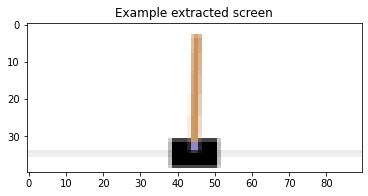

In [7]:
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

## Training

In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [9]:
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

n_actions = env.action_space.n

Объявляем две модели, одна отвечает за политику во время игры, другая для предсказания награды

In [10]:


optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

steps_done = 0

episode_durations = []

Выбор действия

In [11]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1


Визуализация

In [12]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    
    
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

## Training loop

In [13]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    
    
    # batch-array of Transitions to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Парсим transitions чтобы сформировать обучающую выборку
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Вычисляем Q(s_t, a) - Модель предсказывает Q(s_t), 
    # затем мы выбираем Q, соответствующие сделанному действию
    

    # Вычисляем V(s_{t+1}) для всех следующих состояний target_net(non_final_next_states)
    # берем максимальной значение
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    
    
    # Вычисляем ожидаемые значения Q функции
    

    # Вычисляем Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Шаг оптимизации
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

## Основной цикл обучения




In [15]:
num_episodes = 10
for i_episode in range(num_episodes):
    
    # Инициализация
    env.reset()
    
    
    for t in count():
        
        # Выбираем действие
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Наблюдаем новое состояние



        # Сохраняем transition в буфер


        # Делаем шаг оптимизации
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
            
    # Обновляем target network, копирую веса из policy_net
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()

<Figure size 432x288 with 0 Axes>

Complete


<Figure size 432x288 with 0 Axes>